1. 6 5-minute runs with 1s interval to confirm our application-level clock implementation is sane. NTP clock starts off as unsynced and defaults to the system clock. Thus we'll compare the timestamps this clock gives when unsynced with the actual system clock.

data/single_device/system_clock/

pixel_6/

- [x] run1-logcat.txt
- [x] run2-logcat.txt
- [x] run3-logcat.txt

tab_s6/

- [x] run1-logcat.txt
- [x] run2-logcat.txt
- [x] run3-logcat.txt

2. 6 5-minute runs with 1s interval to investigate clock drift. Here we compare the timestamps given by the NTP clock when synced with the system clock.

data/single_device/ntp_clock/

pixel_6/

- [x] run1-logcat.txt
- [x] run2-logcat.txt
- [x] run3-logcat.txt

tab_s6/

- [x] run1-logcat.txt
- [x] run2-logcat.txt
- [x] run3-logcat.txt

3. 10 runs to compare server-side first frame latency between NTP-synced devices and non-NTP-synced/unsynced/system clock devices. All devices start and stop capture at the exact same time.

data/dual_device/system_clock/

- [x] run1.rrd
- [x] run2.rrd
- [x] run3.rrd
- [x] run4.rrd
- [x] run5.rrd

data/dual_device/ntp_clock/

- [x] run1.rrd
- [x] run2.rrd
- [x] run3.rrd
- [x] run4.rrd
- [x] run5.rrd


In [21]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Literal

cmap = plt.get_cmap("tab10", 6)


def parse_logcat(
    file_path: str,
    time_unit: Literal["us"] | Literal["ms"],
    ntp_key: str = "ntp_time",
    system_key: str = "device_time",
):
    timestamps = []
    offsets = []

    with open(file_path, "r") as f:
        for line in f:
            try:
                parts = line.strip().split("Info Unity ")
                if len(parts) < 2:
                    continue
                json_data = json.loads(parts[1])

                ntp_time = datetime.strptime(
                    json_data[ntp_key], "%Y-%m-%dT%H:%M:%S.%f0Z"
                )
                system_time = datetime.strptime(
                    json_data[system_key], "%Y-%m-%dT%H:%M:%S.%f0Z"
                )

                if time_unit == "us":
                    offset = (ntp_time - system_time).total_seconds() * 1e6
                else:
                    offset = (ntp_time - system_time).total_seconds() * 1e3
                timestamps.append(system_time)
                offsets.append(offset)
            except Exception as e:
                print(f"Error parsing line: {line}\nError: {e}")

    if time_unit == "us":
        return pd.DataFrame({"timestamp": timestamps, "offset_us": offsets})
    else:
        return pd.DataFrame({"timestamp": timestamps, "offset_ms": offsets})


def load_experiment_data(
    base_dir: str,
    time_unit: Literal["us"] | Literal["ms"],
    devices: list[str],
    runs: list[str],
    ntp_key: str = "ntp_time",
    system_key: str = "device_time",
):
    data = {}
    for device in devices:
        all_runs = []
        for run in runs:
            file_path = os.path.join(base_dir, device, run)
            df = parse_logcat(file_path, time_unit, ntp_key, system_key)
            df["run"] = run
            df["device"] = device
            df["device_run"] = f"{device} - {run}"
            all_runs.append(df)
        data[device] = pd.concat(all_runs, ignore_index=True)

    return pd.concat(data.values(), ignore_index=True)


def plot_results(all_data: pd.DataFrame, title: str):
    unique_labels = all_data["device_run"].unique()
    color_map = {label: cmap(i) for i, label in enumerate(unique_labels)}

    plt.figure(figsize=(12, 6))
    for label in unique_labels:
        human_readable_label = (
            label.replace("pixel_6", "Pixel 6")
            .replace("tab_s6", "Tab S6")
            .replace("run", "Run ")
            .replace("-logcat.txt", "")
        )

        df_subset = all_data[all_data["device_run"] == label]
        if "offset_us" in df_subset.columns:
            plt.scatter(
                df_subset["timestamp"],
                df_subset["offset_us"],
                label=human_readable_label,
                color=color_map[label],
                s=20,
                alpha=0.7,
            )
        else:
            plt.scatter(
                df_subset["timestamp"],
                df_subset["offset_ms"],
                label=human_readable_label,
                color=color_map[label],
                s=20,
                alpha=0.7,
            )

    plt.axhline(y=0, color="gray", linestyle="--")
    plt.xlabel("Timestamp")
    if "offset_us" in df_subset.columns:
        plt.ylabel("Offset (µs)")
    else:
        plt.ylabel("Offset (ms)")
    plt.title(title)
    plt.legend()
    plt.show()


def compute_statistics(all_data: pd.DataFrame):
    unique_labels = all_data["device_run"].unique()
    for label in unique_labels:
        human_readable_label = (
            label.replace("pixel_6", "Pixel 6")
            .replace("tab_s6", "Tab S6")
            .replace("run", "Run ")
            .replace("-logcat.txt", "")
        )

        df_subset = all_data[all_data["device_run"] == label]
        time_unit_key = "offset_us" if "offset_us" in df_subset.columns else "offset_ms"
        mean_offset = df_subset[time_unit_key].mean()
        median_offset = df_subset[time_unit_key].median()
        std_dev = df_subset[time_unit_key].std()

        time_unit = "µs" if "offset_us" in df_subset.columns else "ms"
        print(f"Device-Run: {human_readable_label}")
        print(f"  Mean Offset: {mean_offset:.3f} {time_unit}")
        print(f"  Median Offset: {median_offset:.3f} {time_unit}")
        print(f"  Standard Deviation: {std_dev:.3f} {time_unit}")

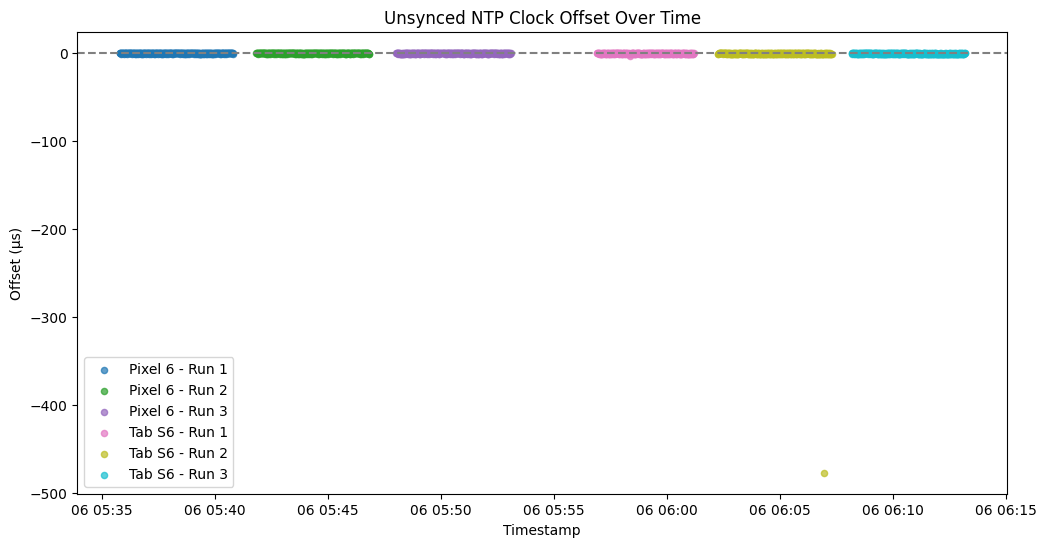

Device-Run: Pixel 6 - Run 1
  Mean Offset: -0.176 µs
  Median Offset: 0.000 µs
  Standard Deviation: 0.382 µs
Device-Run: Pixel 6 - Run 2
  Mean Offset: -0.176 µs
  Median Offset: 0.000 µs
  Standard Deviation: 0.381 µs
Device-Run: Pixel 6 - Run 3
  Mean Offset: -0.244 µs
  Median Offset: 0.000 µs
  Standard Deviation: 0.430 µs
Device-Run: Tab S6 - Run 1
  Mean Offset: -0.417 µs
  Median Offset: 0.000 µs
  Standard Deviation: 0.548 µs
Device-Run: Tab S6 - Run 2
  Mean Offset: -2.081 µs
  Median Offset: 0.000 µs
  Standard Deviation: 27.702 µs
Device-Run: Tab S6 - Run 3
  Mean Offset: -0.531 µs
  Median Offset: -1.000 µs
  Standard Deviation: 0.507 µs


In [22]:
# Experiment 1: Unsynced NTP Clock vs System Clock
base_dir_1 = "data/single_device/system_clock/"
devices_1 = ["pixel_6", "tab_s6"]
runs_1 = ["run1-logcat.txt", "run2-logcat.txt", "run3-logcat.txt"]

exp1_data = load_experiment_data(
    base_dir_1, "us", devices_1, runs_1, ntp_key="ntp_time", system_key="device_time"
)
plot_results(exp1_data, title="Unsynced NTP Clock Offset Over Time")
compute_statistics(exp1_data)

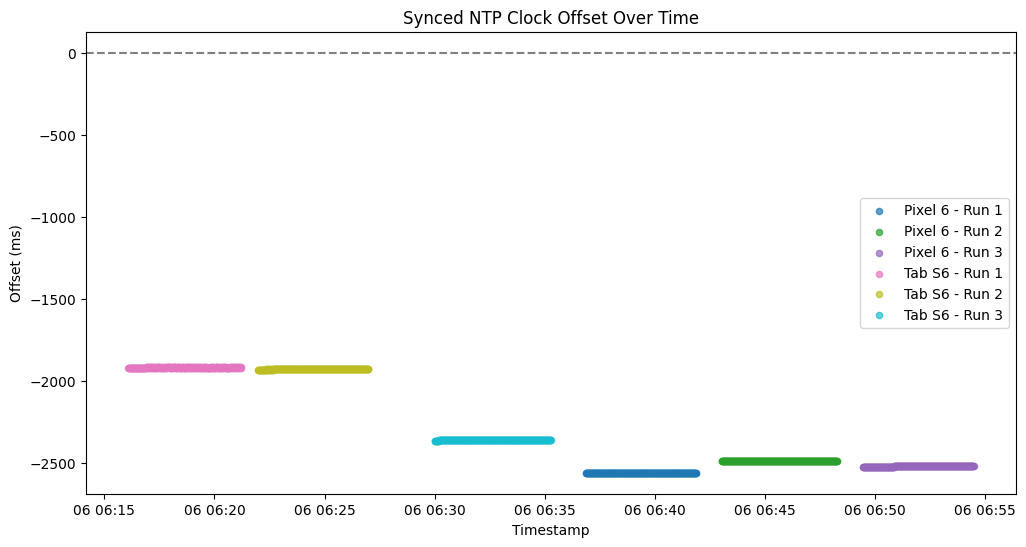

Device-Run: Pixel 6 - Run 1
  Mean Offset: -2559.774 ms
  Median Offset: -2559.792 ms
  Standard Deviation: 0.300 ms
Device-Run: Pixel 6 - Run 2
  Mean Offset: -2487.260 ms
  Median Offset: -2487.274 ms
  Standard Deviation: 0.283 ms
Device-Run: Pixel 6 - Run 3
  Mean Offset: -2521.212 ms
  Median Offset: -2520.671 ms
  Standard Deviation: 1.268 ms
Device-Run: Tab S6 - Run 1
  Mean Offset: -1919.192 ms
  Median Offset: -1918.974 ms
  Standard Deviation: 0.788 ms
Device-Run: Tab S6 - Run 2
  Mean Offset: -1929.133 ms
  Median Offset: -1928.758 ms
  Standard Deviation: 1.163 ms
Device-Run: Tab S6 - Run 3
  Mean Offset: -2359.237 ms
  Median Offset: -2358.876 ms
  Standard Deviation: 1.867 ms


In [23]:
# Experiment 2: NTP Clock (synced) vs System Clock
base_dir_2 = "data/single_device/ntp_clock/"
devices_2 = ["pixel_6", "tab_s6"]
runs_2 = ["run1-logcat.txt", "run2-logcat.txt", "run3-logcat.txt"]

exp2_data = load_experiment_data(
    base_dir_2, "ms", devices_2, runs_2, ntp_key="ntp_time", system_key="device_time"
)
plot_results(exp2_data, title="Synced NTP Clock Offset Over Time")
compute_statistics(exp2_data)

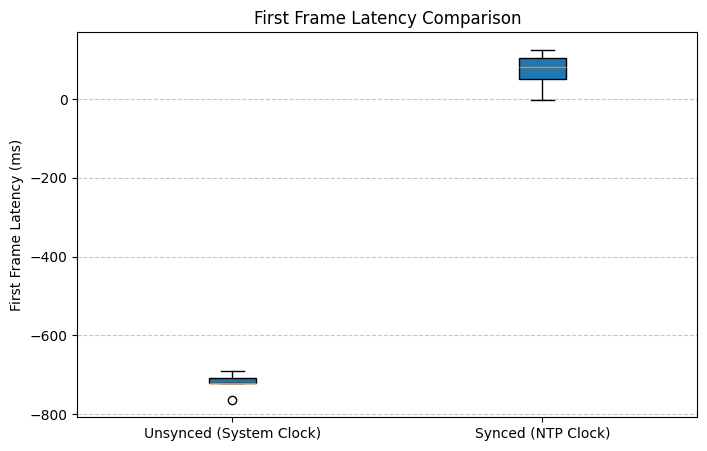

Unsynced (System Clock) First Frame Latency:
  Mean: -720.257 ms
  Median: -720.404 ms
  Std Dev: 27.252 ms

Synced (NTP Clock) First Frame Latency:
  Mean: 71.600 ms
  Median: 82.000 ms
  Std Dev: 49.571 ms



In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import rerun as rr


def compute_first_frame_latency(rrd_path: str):
    recording = rr.dataframe.load_recording(rrd_path)
    view = recording.view(index="device_timestamp", contents="/**")

    df = view.select().read_pandas()

    # Drop any columns with "Color" or "HalfSize3D" in the name, they span all rows
    # so we are not able to correctly determine when the first actual frame from each device was captured
    df = df.loc[:, ~df.columns.str.contains("Color")]
    df = df.loc[:, ~df.columns.str.contains("HalfSize3D")]
    # Convert timestamps to datetime
    df["device_timestamp"] = pd.to_datetime(df["device_timestamp"])

    # Extract column names related to each device
    device_columns = [col for col in df.columns if "gyroscope_frame" in col]

    # Identify unique devices
    devices = list(set(col.split("/")[2] for col in device_columns))

    # Store first frame timestamps
    first_frame_timestamps = {}

    for device in devices:
        device_cols = [col for col in df.columns if device in col]
        first_valid_idx = df[device_cols].dropna(how="all").index.min()

        if pd.notna(first_valid_idx):
            first_frame_timestamps[device] = df.loc[first_valid_idx, "device_timestamp"]

    # Compute first frame latency (difference between two devices)
    timestamps = list(first_frame_timestamps.values())
    if len(timestamps) == 2:
        latency = (timestamps[1] - timestamps[0]).total_seconds() * 1e3  # Convert to ms
        return latency
    else:
        return None


# Paths to datasets
system_clock_dir = "data/multi_device/system_clock/"
ntp_clock_dir = "data/multi_device/ntp_clock/"

# Get all run files
system_clock_runs = sorted(
    [
        os.path.join(system_clock_dir, f)
        for f in os.listdir(system_clock_dir)
        if f.endswith(".rrd")
    ]
)
ntp_clock_runs = sorted(
    [
        os.path.join(ntp_clock_dir, f)
        for f in os.listdir(ntp_clock_dir)
        if f.endswith(".rrd")
    ]
)

# Compute latencies for each run
system_latencies = [compute_first_frame_latency(run) for run in system_clock_runs]
ntp_latencies = [compute_first_frame_latency(run) for run in ntp_clock_runs]

# Remove None values (in case of any errors)
system_latencies = [lat for lat in system_latencies if lat is not None]
ntp_latencies = [lat for lat in ntp_latencies if lat is not None]

# Visualize with a box plot
plt.figure(figsize=(8, 5))
plt.boxplot(
    [system_latencies, ntp_latencies],
    tick_labels=["Unsynced (System Clock)", "Synced (NTP Clock)"],
    patch_artist=True,
)
plt.ylabel("First Frame Latency (ms)")
plt.title("First Frame Latency Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Print statistics
print("Unsynced (System Clock) First Frame Latency:")
print(f"  Mean: {pd.Series(system_latencies).mean():.3f} ms")
print(f"  Median: {pd.Series(system_latencies).median():.3f} ms")
print(f"  Std Dev: {pd.Series(system_latencies).std():.3f} ms\n")

print("Synced (NTP Clock) First Frame Latency:")
print(f"  Mean: {pd.Series(ntp_latencies).mean():.3f} ms")
print(f"  Median: {pd.Series(ntp_latencies).median():.3f} ms")
print(f"  Std Dev: {pd.Series(ntp_latencies).std():.3f} ms\n")